# Introduction

According to the Merriam-Webster dictionary, poetry is defined as "writing that formulates a concentrated imaginative awareness of experience in language chosen and arranged to create a specific emotional response through meaning, sound, and rhythm." 

I find this definition to be quite accurate. As a poetry lover, I often enjoy lines that are packed with connotations and are carefully crafted to not only convay a specific message, but to do so in a cleaver and provoking style. The form a poem takes and the sound that it makes are just as important as what is being said and plays a part in what makes each so unique and special.

For this unsupervised capstone, I have chosen to use a dataset of poetry from 10 of the most renowned poets in history. I have incorporated 14 poems per poet and made an effort to include some of their best known works. That being said, through my exploration of the data, I came to realized that 140 poem to represent 10 different poets does NOT a sufficient sample size make. Especially in terms of being able to classify the poems based on their perspective authors. But, I did discover some interesting insights and ideas on different strategies that could be taken for a future, more thorough unsupervised exploration of poetry.  

I began by importing the poems, constructing the initial dataframe, and populating that dataframe with 4 initial features: 'word_count', 'line_count', 'numb_of_sents', and 'rhyme_count'. For 'rhyme_count', I had to import a library called 'prounouncing' that has the ability to identify all of the distinct sounds with a string. I also found a library called 'prosodic' that had the ability to identify the meter of a poem (its stressed and unstressed syllabic pattern). Unfortunately, it didn't work and the documentation for it stop being updated about 3 years ago.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from string import punctuation
import pronouncing
from sklearn import metrics
from scipy.spatial.distance import cdist
nlp = spacy.load('en')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [44]:
# Here is a function to count the number of rhyming sounds in each poem.

def rhymes(text):
    count = Counter()
    words = text.split()
    for word in words:
        pronunciation_list = pronouncing.phones_for_word(word)
        if len(pronunciation_list) > 0:
            count.update(pronunciation_list[0].split(" "))
    return len({k:v for (k,v) in count.items() if v > 1})

# This part is to remove punctiations and to lower case all of the words

punctuation_symbols = []
for each in list(punctuation):
    punctuation_symbols.append((each, ''))
    
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
        x = x.lower()
    return x

# Creating a list of file names

file_names = open('PoemList.txt', 'r')
file_names = file_names.readlines()
file_names = [file[:-1] for file in file_names]
author_poem = [file[:-4] for file in file_names]

# Getting a list of poem titles and list of poets from the file names 

poem_titles = [re.sub(r'.*_', '', article) for article in author_poem]
poets = [re.sub(r'_.*', '', article) for article in author_poem]

# Creating the lists to fill the rows of data

poems = []
word_count = []
line_count = []
num_of_sents = []
processed_poems = []
max_sent_length = []
min_sent_length = []
no_punct_poems = []
processed_no_punct = []
num_of_rhymes = []

# Loop through every file name to fill the lists 

for text in file_names:
    opened = open(text, 'r').read()
    poem = opened.replace("\n"," ")
    poem = poem.replace('-', ' ')
    poem = ' '.join(poem.split())
    poems.append(poem)
    
    sentences = re.split(r'[.!?]', poem)
    if '' in sentences: 
        sentences.remove('')
    num_of_sents.append(len(sentences))
    
    no_punct = remove_puncuation(poem)
    no_punct_poems.append(no_punct)
    
    rhyme_count = rhymes(no_punct)
    num_of_rhymes.append(rhyme_count)
    
    wordcount = Counter(no_punct.split())
    wordcount = sum(wordcount.values())
    word_count.append(wordcount)
    
    no_punct = nlp(no_punct)
    processed_no_punct.append(no_punct)
    
    num_lines = sum(1 for line in open(text))
    line_count.append(num_lines)
    
    sentences = nlp(poem)
    processed_poems.append(sentences)

# Use the lists to fill the dataframe

poems_df = pd.DataFrame()
poems_df['poem'] = poems
poems_df["poem_titles"] = poem_titles
poems_df['authors'] = poets
poems_df['word_count'] = word_count
poems_df['line_count'] = line_count
poems_df['num_of_sents'] = num_of_sents
poems_df['processed_poems'] = processed_poems
poems_df['no_punct_cap_poems'] = no_punct_poems
poems_df['processed_no_punct'] = processed_no_punct
poems_df['rhyme_count'] = num_of_rhymes

poems_df.head()

,poem,poem_titles,authors,word_count,line_count,num_of_sents,processed_poems,no_punct_cap_poems,processed_no_punct,rhyme_count
0,"Lying, thinking Last night How to find my soul...",Alone,Angelou,162,42,7,"(Lying, ,, thinking, Last, night, How, to, fin...",lying thinking last night how to find my soul ...,"(lying, thinking, last, night, how, to, find, ...",38
1,"Curtains forcing their will against the wind, ...",AwakingInNewYork,Angelou,38,11,2,"(Curtains, forcing, their, will, against, the,...",curtains forcing their will against the wind c...,"(curtains, forcing, their, will, against, the,...",27
2,A free bird leaps on the back of the wind and ...,CagedBird,Angelou,193,43,5,"(A, free, bird, leaps, on, the, back, of, the,...",a free bird leaps on the back of the wind and ...,"(a, free, bird, leaps, on, the, back, of, the,...",35
3,"The eye follows, the land Slips upward, crease...",CaliforniaProdigal,Angelou,130,35,8,"(The, eye, follows, ,, the, land, Slips, upwar...",the eye follows the land slips upward creases ...,"(the, eye, follows, the, land, slips, upward, ...",39
4,"One foot down, then hop! It's hot. Good things...",HarlemHopscotch,Angelou,90,17,14,"(One, foot, down, ,, then, hop, !, It, 's, hot...",one foot down then hop its hot good things for...,"(one, foot, down, then, hop, its, hot, good, t...",38


In [45]:
poems_df.describe()

,word_count,line_count,num_of_sents,rhyme_count
count,140.000000,140.000000,140.000000,140.000000
mean,147.192857,25.657143,7.357143,35.278571
std,135.219401,23.496754,7.839277,6.459690
min,16.000000,2.000000,1.000000,14.000000
25%,67.500000,14.000000,2.000000,32.000000
50%,113.000000,17.000000,5.000000,37.000000
75%,159.000000,29.000000,9.250000,39.000000
max,814.000000,140.000000,43.000000,48.000000


### I did a correlation matrix for the features that I had to see if any of them are highly correlated.

              word_count  line_count  num_of_sents  rhyme_count
word_count      1.000000    0.929102      0.706035     0.669578
line_count      0.929102    1.000000      0.692724     0.616958
num_of_sents    0.706035    0.692724      1.000000     0.525237
rhyme_count     0.669578    0.616958      0.525237     1.000000


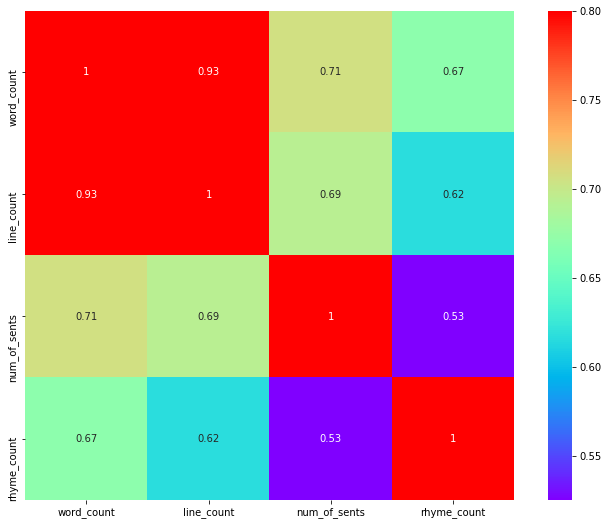

In [46]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems',
       'no_punct_cap_poems', 'processed_no_punct'], axis = 1)

# Make the correlation matrix.

corrmat = X.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap = 'rainbow')
plt.show()

### Since 'line_count' and 'word_count' are so highly correlated, I'll just use 'word_count' for my clusters. This will actually make visualizing the results easier.

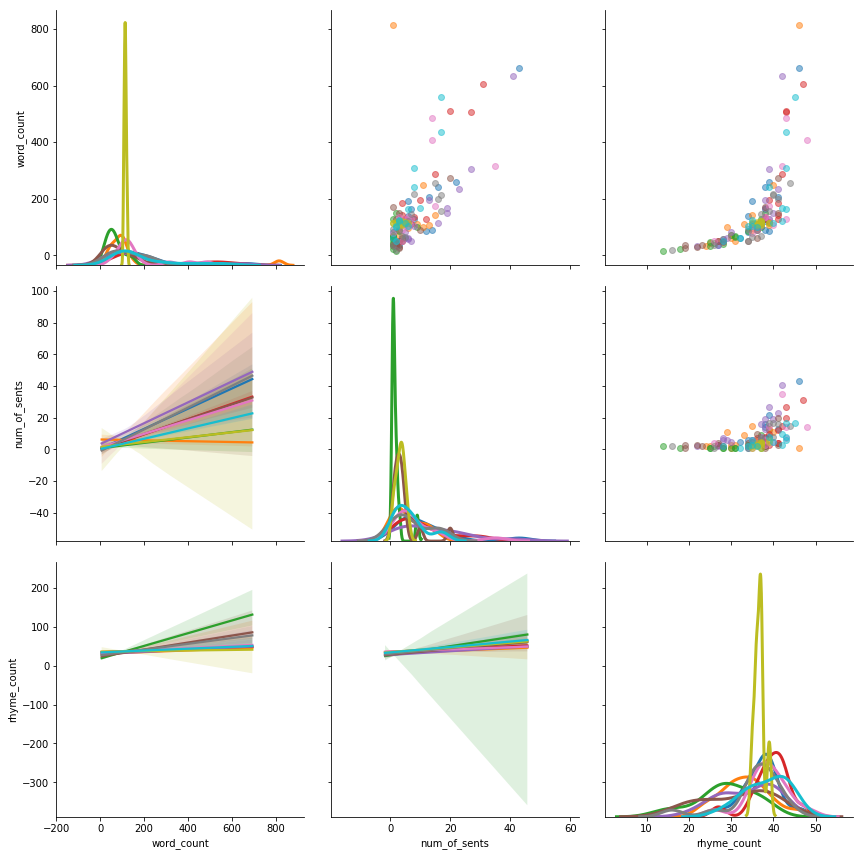

In [5]:
X = poems_df.drop(['poem_titles','poem','processed_poems',
       'no_punct_cap_poems', 'processed_no_punct','line_count'], axis = 1)


# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(X.dropna(), hue='authors', size= 4, diag_sharey=False)

# Scatterplot.
g = g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g = g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g = g.map_diag(sns.kdeplot, lw=3)

# Tried adding a legend but the colors keys wouldn't show
# g = g.add_legend()

plt.show()

In [6]:
poems_df[poems_df['word_count']>800]

,poem,poem_titles,authors,word_count,line_count,num_of_sents,processed_poems,no_punct_cap_poems,processed_no_punct,rhyme_count
17,To see a World in a Grain of Sand And a Heave...,AuguriesOfInnocence,Blake,814,132,1,"(To, see, a, World, in, a, Grain, of, Sand, ,...",to see a world in a grain of sand and a heave...,"(to, see, a, world, in, a, grain, of, sand, ,...",46


# Cluster Analysys

With these 4 features, however, I did my first clustering. 

An elbow graph using the k-means yeilded 4 as the optimum number of clusters.

Running the 'explained_variance' function with PCA revieled that nearly 99% of all variance was covered by the top 3 features, so I decided to do a 3d plot to visualize the data.

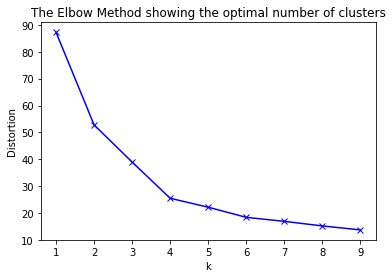

In [47]:
X = poems_df.loc[:,['word_count', 'num_of_sents','rhyme_count']]

# Calculating the distortions for number of clusters from 1-9

distortions = []

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
# Plotting the elboy graph

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

In [48]:
X = poems_df.loc[:,['word_count', 'num_of_sents','rhyme_count']]

X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([ 0.95398555,  0.03823439,  0.00778006])

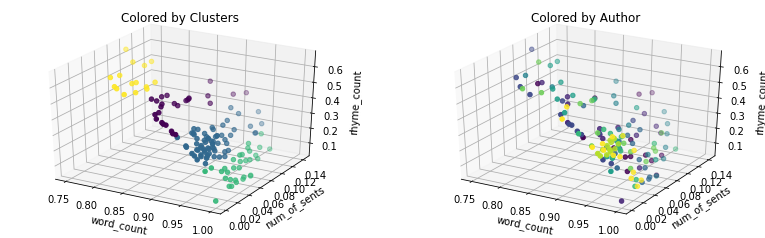

In [49]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1, projection='3d')

X = poems_df.loc[:,['word_count', 'num_of_sents','rhyme_count']]

X_norm = normalize(X)

y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_norm)

ax.scatter(X_norm[:, [0]], X_norm[:, [1]], X_norm[:,[2]], c=y_pred)

ax.set_xlabel('word_count')
ax.set_ylabel('num_of_sents')
ax.set_zlabel('rhyme_count')
ax.set_title('Colored by Clusters')

ax = fig.add_subplot(1, 2, 2, projection='3d')

X_norm = normalize(X)

y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_norm)

# Change the author names into numbers to be used color values for graph

poems_df['author_codes'] = pd.Categorical(poems_df['authors'])
poems_df['author_codes'] = poems_df.author_codes.cat.codes

ax.scatter(X_norm[:, [0]], X_norm[:, [1]], X_norm[:,[2]], c=poems_df.author_codes)

ax.set_xlabel('word_count')
ax.set_ylabel('num_of_sents')
ax.set_zlabel('rhyme_count')

ax.set_title('Colored by Author')

plt.show()

In [50]:
cluster_df = poems_df.copy()
cluster_df['cluster'] = y_pred

describe0 = cluster_df.loc[cluster_df['cluster']== 0, ['word_count', 'num_of_sents','rhyme_count']].describe()
describe1 = cluster_df.loc[cluster_df['cluster']== 1, ['word_count', 'num_of_sents','rhyme_count']].describe()
describe2 = cluster_df.loc[cluster_df['cluster']== 2, ['word_count', 'num_of_sents','rhyme_count']].describe()
describe3 = cluster_df.loc[cluster_df['cluster']== 3, ['word_count', 'num_of_sents','rhyme_count']].describe()

describe0.columns = ['word_count0', 'num_of_sents0', 'rhyme_count0']
describe1.columns = ['word_count1', 'num_of_sents1', 'rhyme_count1']
describe2.columns = ['word_count2', 'num_of_sents2', 'rhyme_count2']
describe3.columns = ['word_count3', 'num_of_sents3', 'rhyme_count3']

result = pd.concat([describe0,describe1,describe2,describe3], axis=1)
print('word_count Means:\n', result.loc['mean',['word_count0','word_count1','word_count2','word_count3']], '\n')
print('num_of_sents Means:\n', result.loc['mean',['num_of_sents0','num_of_sents1','num_of_sents2','num_of_sents3']], '\n')
print('rhyme_count Means:\n', result.loc['mean',['rhyme_count0','rhyme_count1','rhyme_count2','rhyme_count3']], '\n')

word_count Means:
 word_count0     58.846154
word_count1    117.641791
word_count2    334.187500
word_count3     33.400000
Name: mean, dtype: float64 

num_of_sents Means:
 num_of_sents0     3.615385
num_of_sents1     5.447761
num_of_sents2    16.906250
num_of_sents3     2.000000
Name: mean, dtype: float64 

rhyme_count Means:
 rhyme_count0    30.038462
rhyme_count1    36.940299
rhyme_count2    41.375000
rhyme_count3    23.933333
Name: mean, dtype: float64 



The plot on the left visualizes the clusters that k-means produced. On the right, the data points are colored by author. As you can see, the spread of the authors was pretty random. 

This makes sense since, at the moment, the features are representive of the basic measurements of the poems: how many words, how many sentences, and how many rhymes. Poets, in general, tend to write poetry of varying lengths throughout their career. So all of their works being grouped together solely by their length is probably not going happen. That being said, if the data set included their complete bodies of work, there may be a distinct pattern of the prefered poem length for each writer.

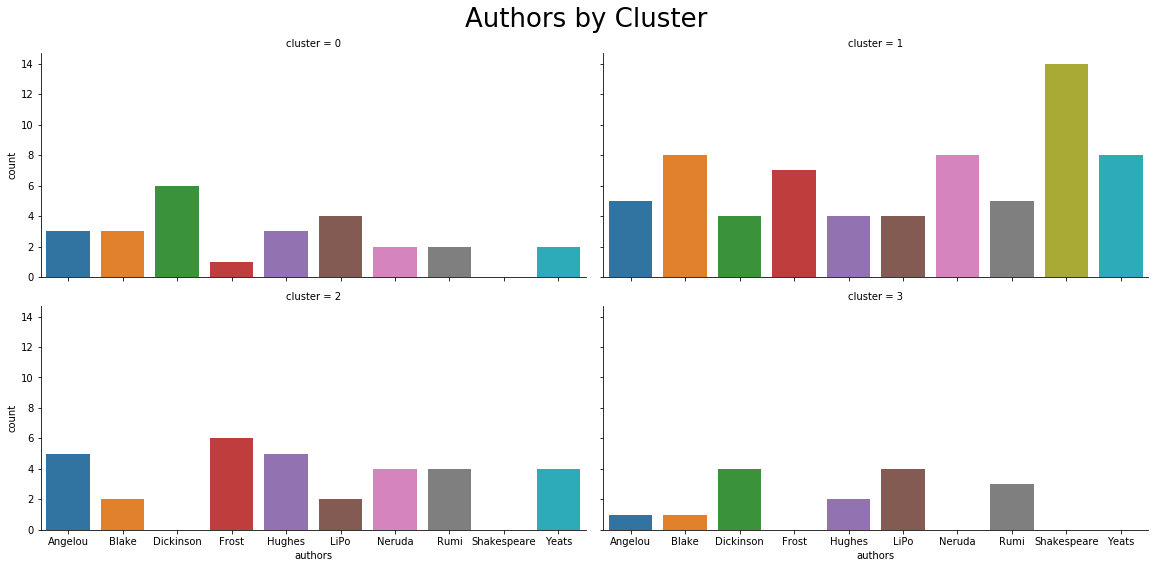

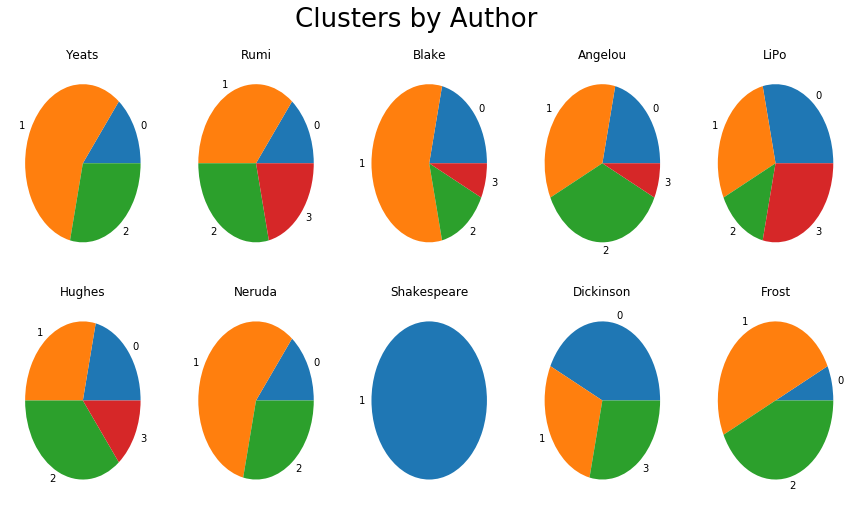

In [51]:
sns.factorplot("authors", col="cluster", col_wrap=2,data=cluster_df,kind="count", aspect=2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Authors by Cluster', fontsize=26)
plt.show()


f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5,figsize=(15,8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for author, axe in zip(set(poems_df.authors), axes):
    cluster = cluster_df[cluster_df['authors']==author]
    cluster_counter = Counter(list(cluster['cluster']))
    keys = cluster_counter.keys()
    values = cluster_counter.values()
    axe.pie([float(v) for v in values], labels=keys,
               autopct=None)
    axe.set_title(author)

plt.suptitle('Clusters by Author', fontsize=26)

plt.show()

# Adding Bag-Of-Words Features...

### I added the bag of words features to see if it would improve the clusters so that the poems would be clustered by author.

In [12]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return allwords

def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_no_punct'] = sentences['processed_no_punct']
    df['authors'] = sentences['authors']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_no_punct']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [13]:
set_bag = []

for i, poem in enumerate(poems_df['processed_no_punct']):
    allwords = bag_of_words(poem)
    set_bag.extend(allwords)
    
set_bag = set(set_bag)

In [59]:
bow_df = bow_features(poems_df, set_bag)

Processing row 0


In [60]:
bow_cluster = bow_df.copy().drop(['processed_no_punct','authors'], 1)
bow_cluster['word_count'] = poems_df['word_count']
bow_cluster['num_of_sents'] = poems_df['num_of_sents']
bow_cluster['rhyme_count'] = poems_df['rhyme_count']

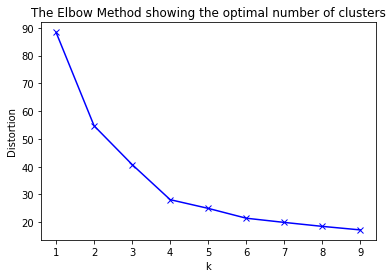

In [61]:
X = bow_cluster

distortions = []

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
# Plotting the elboy graph

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

In [62]:
X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance[:5]

array([ 0.75085037,  0.03210687,  0.00903624,  0.00810509,  0.00734937])

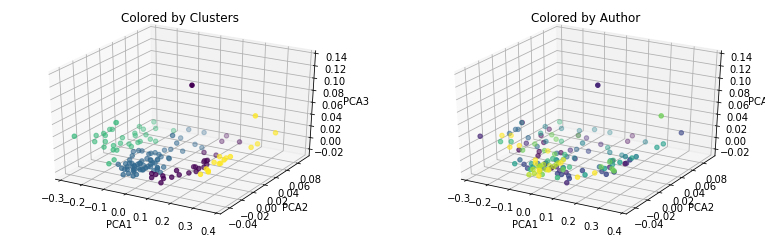

In [63]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1, projection='3d')

X_norm = normalize(X)

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X_norm)

y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)

ax.scatter(X_pca[:, [0]], X_pca[:, [1]], X_pca[:,[2]], c=y_pred)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Colored by Clusters')

ax = fig.add_subplot(1, 2, 2, projection='3d')

# Change the author names into numbers to be used color values for graph

poems_df['author_codes'] = pd.Categorical(poems_df['authors'])
poems_df['author_codes'] = poems_df.author_codes.cat.codes

ax.scatter(X_pca[:, [0]], X_pca[:, [1]], X_pca[:,[2]], c=poems_df.author_codes)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Colored by Author')

plt.show()

In [68]:
cluster2_df = poems_df.copy()
cluster2_df['cluster'] = y_pred

describe0 = cluster2_df.loc[cluster2_df['cluster']== 0, ['word_count', 'num_of_sents','rhyme_count']].describe()
describe1 = cluster2_df.loc[cluster2_df['cluster']== 1, ['word_count', 'num_of_sents','rhyme_count']].describe()
describe2 = cluster2_df.loc[cluster2_df['cluster']== 2, ['word_count', 'num_of_sents','rhyme_count']].describe()
describe3 = cluster2_df.loc[cluster2_df['cluster']== 3, ['word_count', 'num_of_sents','rhyme_count']].describe()

describe0.columns = ['word_count0', 'num_of_sents0', 'rhyme_count0']
describe1.columns = ['word_count1', 'num_of_sents1', 'rhyme_count1']
describe2.columns = ['word_count2', 'num_of_sents2', 'rhyme_count2']
describe3.columns = ['word_count3', 'num_of_sents3', 'rhyme_count3']

result = pd.concat([describe0,describe1,describe2,describe3], axis=1)
print('word_count Means:\n', result.loc['mean',['word_count0','word_count1','word_count2','word_count3']], '\n')
print('num_of_sents Means:\n', result.loc['mean',['num_of_sents0','num_of_sents1','num_of_sents2','num_of_sents3']], '\n')
print('rhyme_count Means:\n', result.loc['mean',['rhyme_count0','rhyme_count1','rhyme_count2','rhyme_count3']], '\n')

word_count Means:
 word_count0     58.846154
word_count1    117.641791
word_count2    334.187500
word_count3     33.400000
Name: mean, dtype: float64 

num_of_sents Means:
 num_of_sents0     3.615385
num_of_sents1     5.447761
num_of_sents2    16.906250
num_of_sents3     2.000000
Name: mean, dtype: float64 

rhyme_count Means:
 rhyme_count0    30.038462
rhyme_count1    36.940299
rhyme_count2    41.375000
rhyme_count3    23.933333
Name: mean, dtype: float64 



### Adding the Bag of Words yeilded virtually the same results. I will now try the Bag of Words by itself to see if any interesting clusters emmerge.

In [69]:
bow_df.head()

,die’,reach,defeat,table,raise,begin,fine,endless,singing,peeper,...,chatter,atavism,terrible,law,heavenly,gangster,insect,grow,processed_no_punct,authors
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(lying, thinking, last, night, how, to, find, ...",Angelou
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(curtains, forcing, their, will, against, the,...",Angelou
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(a, free, bird, leaps, on, the, back, of, the,...",Angelou
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(the, eye, follows, the, land, slips, upward, ...",Angelou
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(one, foot, down, then, hop, its, hot, good, t...",Angelou


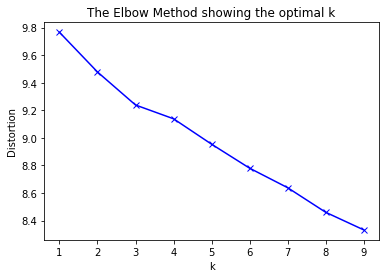

In [70]:
X2 = bow_df.copy().drop(['processed_no_punct','authors'], 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X2)
    kmeanModel.fit(X2)
    distortions.append(sum(np.min(cdist(X2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### The elbow plot shows a slight bend at 3 clusters. But, it isn't significant enough to warrant justifying 3 clusters as the optimum choice.

In [71]:
X2_norm = normalize(X2)

pca = PCA(n_components = None)
# Reduce it to two components.
X2_pca = pca.fit_transform(X2_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance[:5]

array([ 0.03505432,  0.02208338,  0.01989722,  0.01839132,  0.01692776])

### The explained variance only covered about 7%. So a PCA visualization would unfortunately prove useless. 

### Here are the poems/authors reshuffled into their new clusters. I chose 3 clusters despite how slight the bend was. As you can see, the poems are still not grouped together by their perspective authors. 

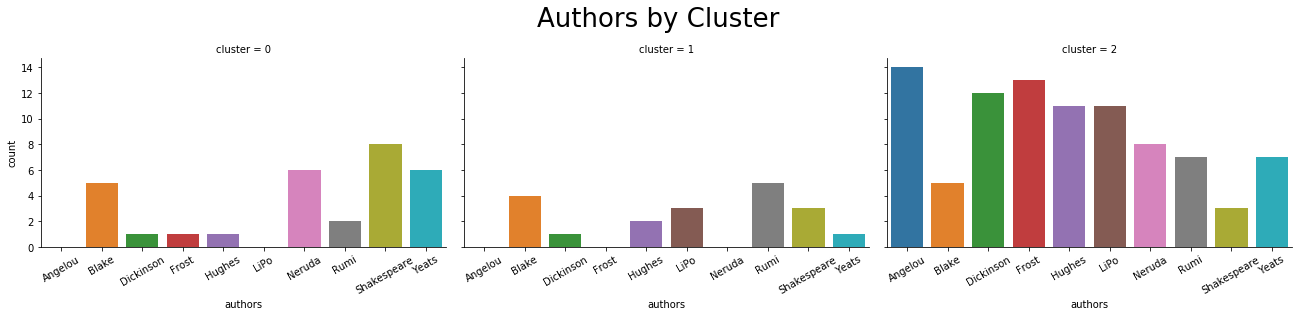

In [80]:
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X2_norm)

bow_cluster3_df = poems_df.copy()
bow_cluster3_df['cluster'] = y_pred

g = sns.factorplot("authors", col="cluster", col_wrap=3,data=bow_cluster3_df,kind="count", aspect=1.5)
g.set_xticklabels(rotation=30)
plt.subplots_adjust(top=0.8)
plt.suptitle('Authors by Cluster', fontsize=26)
plt.show()

### I looked at the shape of each cluster and determined that each cluster does only share a specific set of words.

In [81]:
hello = bow_df.copy()
hello['cluster'] = y_pred

hello2 = hello.loc[hello['cluster']== 2, :]
a = hello2.loc[:, (hello2 != 0).any(axis=0)]

hello0 = hello.loc[hello['cluster']== 0, :]
b = hello0.loc[:, (hello0 != 0).any(axis=0)]

hello1 = hello.loc[hello['cluster']== 1, :]
c = hello1.loc[:, (hello1 != 0).any(axis=0)]

print(a.shape[1], b.shape[1], c.shape[1], hello.shape[1])

2539 896 465 3049


### Below are the top 10 most frequent words for the 3 clusters. As you can see, the poems are clustered by the words that they share. This may be useful for clustering poems by theme, but I'm usure if this would prove useful in being able to distiguish a poem by its author. 

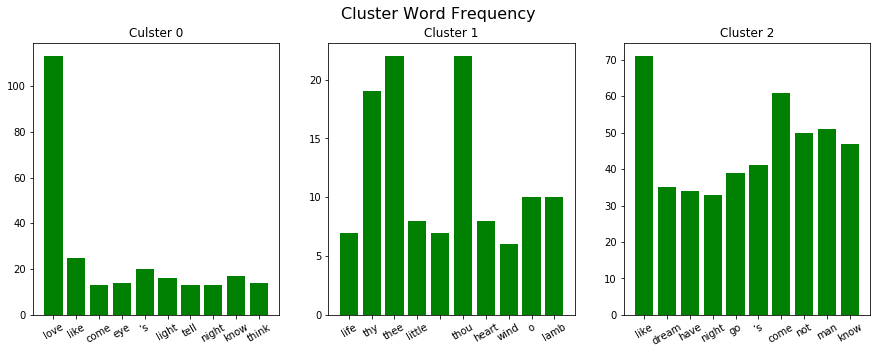

In [102]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(15,5))

axes = [ax1, ax2, ax3]
groups = [b, c, a]
titles = ['Culster 0', 'Cluster 1', 'Cluster 2']

for i in range(3):
    group = groups[i]
    ax = axes[i]
    title = titles[i]
    answers = group[list(group.columns)].sum()
    answers = answers.to_frame()
    if 'cluster' in group.columns:
        answers = answers.drop(['cluster'])
    answers = answers.drop(['authors'])
    answers[[0]] = answers[[0]].astype(float)
    answers = answers.nlargest(10, 0, keep ='first')
    answers = answers.to_dict()
    
    ran = np.arange(len(list(answers[0].keys())))
    ax.bar(ran, list(answers[0].values()), color='g')
    ax.set_xticks(np.arange(len(list(answers[0].keys()))))
    ax.set_xticklabels(list(answers[0].keys()), rotation=30)
    ax.set_title(title)
    

plt.suptitle('Cluster Word Frequency', fontsize=16)

plt.show()

# Using predictive models

### I will now use predictive models to see if they are more successful in categorizing the poems by author. 

### Ultimately, here is where it became clear that I did not have enough data to make effective predictive models.

### I used the initial 4 features for the first models. It did not perform very well.

In [76]:
X = poems_df.loc[:,['word_count', 'line_count', 'num_of_sents','rhyme_count']]
Y = poems_df['authors']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [77]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.980952380952
Test set score: 0.228571428571

Logistic Regression:
Training set score: 0.438095238095
Test set score: 0.228571428571

Gradient Boosting Classifier:
Training set score: 0.990476190476
Test set score: 0.2

Support Vector Machine:
Training set score: 0.571428571429
Training set score: 0.285714285714


### The following predictive models used the bag of words as its features and that was not much of an improvement either.

In [78]:
Y = bow_df['authors']
X = np.array(bow_df.drop(['processed_no_punct','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.980952380952
Test set score: 0.2

Logistic Regression:
Training set score: 1.0
Test set score: 0.371428571429

Gradient Boosting Classifier:
Training set score: 1.0
Test set score: 0.228571428571

Support Vector Machine:
Training set score: 1.0
Training set score: 0.257142857143


### Combining the two was no help.

In [28]:
bow_df['word_count'] = poems_df['word_count']
bow_df['line_count'] = poems_df['line_count']
bow_df['num_of_sents'] = poems_df['num_of_sents']
bow_df['rhyme_count'] = poems_df['rhyme_count']

Y = bow_df['authors']
X = np.array(bow_df.drop(['processed_no_punct','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.990476190476
Test set score: 0.2

Logistic Regression:
Training set score: 1.0
Test set score: 0.285714285714

Gradient Boosting Classifier:
Training set score: 1.0
Test set score: 0.285714285714

Support Vector Machine:
Training set score: 1.0
Training set score: 0.314285714286


### I redid the bag of word features on a sentence level. This had the effect of having over 700 samples as opposed to the original 140. There was a small improvement, but still nothing over a 50% accuracy rate.

In [29]:
test = []
for i, poem in enumerate(poems_df['processed_no_punct']):
    poem_sents = [[sent, poems_df.loc[i,'authors']] for sent in poems_df.loc[i,'processed_no_punct'].sents]
    test.extend(poem_sents)

sentences_df = pd.DataFrame(test, columns = ['processed_no_punct','authors'])
sentences_df.head()

,processed_no_punct,authors
0,"(lying, thinking, last, night, how, to, find, ...",Angelou
1,"(i, came, up, with, one, thing, and, i, do, n’...",Angelou
2,"(all, alone, nobody, but, nobody, can, make, i...",Angelou
3,"(but, nobody, no, nobody, can, make, it, out, ...",Angelou
4,"(nobody, but, nobody, can, make, it, out, here...",Angelou


In [30]:
def bow_features2(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_no_punct'] = sentences['processed_no_punct']
    df['authors'] = sentences['authors']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_no_punct']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [31]:
bow_df2 = bow_features2(sentences_df, set_bag)

Processing row 0
Processing row 500


In [32]:
Y = bow_df2['authors']
X = np.array(bow_df2.drop(['processed_no_punct','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.960413080895
Test set score: 0.365979381443

Logistic Regression:
Training set score: 0.932874354561
Test set score: 0.448453608247

Gradient Boosting Classifier:
Training set score: 0.931153184165
Test set score: 0.335051546392

Support Vector Machine:
Training set score: 0.97074010327
Training set score: 0.360824742268


### I also did DF-IDF features, but still no improvement.

In [33]:
corpus = []
for i in range(poems_df.shape[0]):
    corpus.append(poems_df.loc[i,'no_punct_cap_poems'])

In [34]:
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_

In [35]:
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))

In [36]:
idf_words = list(idf_dict.keys())

In [37]:
def idf_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_no_punct'] = sentences['processed_no_punct']
    df['authors'] = sentences['authors']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_no_punct']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += idf_dict[word]
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [38]:
dfidf_df = idf_features(poems_df, idf_words)

Processing row 0


In [39]:
Y = dfidf_df['authors']
X = np.array(dfidf_df.drop(['processed_no_punct','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.990476190476
Test set score: 0.142857142857

Logistic Regression:
Training set score: 1.0
Test set score: 0.428571428571

Gradient Boosting Classifier:
Training set score: 1.0
Test set score: 0.2

Support Vector Machine:
Training set score: 1.0
Training set score: 0.314285714286


### On a sentence level, there was no improvement either...

In [40]:
dfidf_df2 = idf_features(sentences_df, idf_words)

Processing row 0
Processing row 500


In [41]:
Y = dfidf_df2['authors']
X = np.array(dfidf_df2.drop(['processed_no_punct','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.948364888124
Test set score: 0.345360824742

Logistic Regression:
Training set score: 0.95008605852
Test set score: 0.381443298969

Gradient Boosting Classifier:
Training set score: 0.910499139415
Test set score: 0.29381443299

Support Vector Machine:
Training set score: 0.951807228916
Training set score: 0.283505154639


### Truncating the df-idf features didn't help either.

In [42]:
#Our SVD data reducer.  We are going to reduce the feature space to 130

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
dfidf_df2_lsa = lsa.fit_transform(X)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(dfidf_df2_lsa,index=dfidf_df2.index)

Percent variance captured by all components: 64.6419251533


In [43]:
Y = dfidf_df2['authors']
X = np.array(paras_by_component)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, Y_train)

print('\nGradient Boosting Classifier:')
print('Training set score:', clf.score(X_train, Y_train))
print('Test set score:', clf.score(X_test, Y_test))

svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('\nSupport Vector Machine:')
print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))


Random Forest Classifier:
Training set score: 0.951807228916
Test set score: 0.283505154639

Logistic Regression:
Training set score: 0.631669535284
Test set score: 0.407216494845

Gradient Boosting Classifier:
Training set score: 0.965576592083
Test set score: 0.29381443299

Support Vector Machine:
Training set score: 0.690189328744
Training set score: 0.381443298969
